In [34]:
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet50
import torch.nn.functional as F
from torch import nn
from torch import optim

import json
import os
import time

# Load Training/Test Data

In [26]:
from os.path import exists

if not exists('original') :
  !wget only_bg_t.tar.gz https://www.dropbox.com/s/03lk878q73hyjpi/only_bg_t.tar.gz?dl=0
  !wget original.tar.gz https://www.dropbox.com/s/0vv2qsc4ywb4z5v/original.tar.gz?dl=0
  
  !tar -xf 'only_bg_t.tar.gz'
  !tar -xf 'original.tar.gz'


In [27]:
# Show image

In [28]:
preprocess = transforms.Compose([
  transforms.Resize(256), 
  transforms.CenterCrop(224), 
  transforms.ToTensor(), 
  transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
  )])

trainset_only_bg_t = ImageFolder('./only_bg_t/train', transform=preprocess)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  00_dog 0


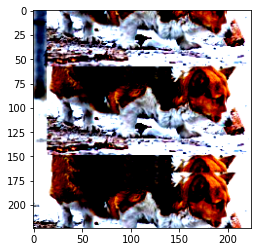

In [29]:

import matplotlib.pyplot as plt

def show_example(img, label, dataset):
    print('Label: ', dataset.classes[label], label)
    plt.imshow(img.permute(1, 2, 0)) 

show_example(*trainset_only_bg_t[4000], trainset_only_bg_t) 


# Fine-tuning ResNet50

In [31]:
len(original_testset.classes)


9

In [32]:
# Step1: initialize model

model_ft = resnet50(pretrained=True)

model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))

model_ft.fc = nn.Linear(2048, len(original_testset.classes))


In [35]:
# Step2: Freeze layers by not tracking gradients
for param in model_ft.parameters():
    param.requires_grad = False

model_ft.fc.weight.requires_grad = True # unfreeze last layer weights
model_ft.fc.bias.requires_grad = True #unfreeze last layer biases

# create optimizer
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model_ft.parameters()), lr=1e-4) #only optimse non-frozen layers

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 10


In [39]:
# Step3: 
batch_size=64

data_transforms = {
    'only_bg_t/train': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
    'only_bg_t/val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'original/val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: ImageFolder('./'+x, data_transforms[x]) for x in ['only_bg_t/train', 'only_bg_t/val', 'original/val'] }

# Create training and validation dataloaders
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['only_bg_t/train', 'only_bg_t/val', 'original/val'] }



Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [44]:
# https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb
# https://www.kaggle.com/frozenwolf/coronahack-finetuning-resnet18-pytorch
import matplotlib.pyplot as plt
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since = time.time()

    only_bg_t_val_acc_history = []
    only_bg_t_train_acc_history = []
    original_val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['only_bg_t/train', 'only_bg_t/val', 'original/val']:
            if phase == 'only_bg_t/train':
                model.train()  # Set model to training mode
            else:
               model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'only_bg_t/train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'only_bg_t/train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'only_bg_t/val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
           
            if phase == 'only_bg_t/val':
                only_bg_t_val_acc_history.append(epoch_acc)
           
            if phase == 'original/val':
                original_val_acc_history.append(epoch_acc)

            if phase == 'only_bg_t/train':
                only_bg_t_train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, only_bg_t_train_acc_history, only_bg_t_val_acc_history, original_val_acc_history


In [45]:
# Step4: 

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Train and evaluate
model_ft, only_bg_t_train_acc_history, only_bg_t_val_acc_history, original_val_acc_history = train_model(model_ft, 
                                                           dataloaders_dict, 
                                                           criterion, 
                                                           optimiser, 
                                                           num_epochs=num_epochs)


Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


only_bg_t/train Loss: 1.5102 Acc: 0.5040
only_bg_t/val Loss: 1.2869 Acc: 0.5570
original/val Loss: 1.0107 Acc: 0.7632

Epoch 1/9
----------
only_bg_t/train Loss: 1.2460 Acc: 0.5700
only_bg_t/val Loss: 1.2158 Acc: 0.5773
original/val Loss: 0.8115 Acc: 0.8196

Epoch 2/9
----------
only_bg_t/train Loss: 1.2011 Acc: 0.5813
only_bg_t/val Loss: 1.1926 Acc: 0.5828
original/val Loss: 0.7592 Acc: 0.8198

Epoch 3/9
----------
only_bg_t/train Loss: 1.1785 Acc: 0.5870
only_bg_t/val Loss: 1.1820 Acc: 0.5907
original/val Loss: 0.7439 Acc: 0.8162

Epoch 4/9
----------
only_bg_t/train Loss: 1.1665 Acc: 0.5888
only_bg_t/val Loss: 1.1728 Acc: 0.5900
original/val Loss: 0.7169 Acc: 0.8265

Epoch 5/9
----------
only_bg_t/train Loss: 1.1566 Acc: 0.5940
only_bg_t/val Loss: 1.1691 Acc: 0.5933
original/val Loss: 0.7207 Acc: 0.8170

Epoch 6/9
----------
only_bg_t/train Loss: 1.1481 Acc: 0.5979
only_bg_t/val Loss: 1.1645 Acc: 0.5967
original/val Loss: 0.7078 Acc: 0.8332

Epoch 7/9
----------
only_bg_t/train Loss

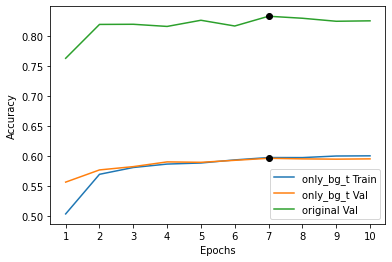

In [58]:
import numpy as np

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(range(1, num_epochs+1), only_bg_t_train_acc_history, label="only_bg_t Train")
plt.plot(range(1, num_epochs+1), only_bg_t_val_acc_history, label="only_bg_t Val")
plt.plot(range(1, num_epochs+1), original_val_acc_history, label="original Val")

plt.plot(np.argmax(only_bg_t_val_acc_history) + 1, np.max(only_bg_t_val_acc_history).item(), "ko")
plt.plot(np.argmax(original_val_acc_history) + 1, np.max(original_val_acc_history).item(), "ko")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


In [ ]:
def evaluation(model_ft, dataloader):
  model_ft.eval()
  test_corrects = 0
  for inputs, labels in dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
    test_corrects += torch.sum(preds == labels.data)
  print(test_corrects.double() / len(dataloader.dataset))


In [75]:

evaluation(model_ft, dataloaders_dict['only_bg_t/val'])

evaluation(model_ft, dataloaders_dict['original/val'])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.5967, device='cuda:0', dtype=torch.float64)
tensor(0.8332, device='cuda:0', dtype=torch.float64)


# ResNet18


In [73]:
# Step1: initialize model
from torchvision.models import resnet18

model_18 = resnet18(pretrained=True)
model_18.avgpool = nn.AdaptiveAvgPool2d((1,1))
model_18.fc = nn.Linear(512, len(original_testset.classes))


# Step2: Freeze layers by not tracking gradients
for param in model_18.parameters():
    param.requires_grad = False

model_18.fc.weight.requires_grad = True # unfreeze last layer weights
model_18.fc.bias.requires_grad = True #unfreeze last layer biases

# Step3: create optimizer
optimiser = optim.Adam(filter(lambda p: p.requires_grad, model_18.parameters()), lr=1e-4) #only optimse non-frozen layers


# Step4: Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Number of epochs to train for 
num_epochs = 10


# Step5: 

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_18 = model_18.to(device)

# Train and evaluate
model_18, only_bg_t_train_acc_history_18, only_bg_t_val_acc_history_18, original_val_acc_history_18 = train_model(model_18, 
                                                           dataloaders_dict, 
                                                           criterion, 
                                                           optimiser, 
                                                           num_epochs=num_epochs)


Epoch 0/9
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


only_bg_t/train Loss: 1.7640 Acc: 0.3826
only_bg_t/val Loss: 1.4800 Acc: 0.4937
original/val Loss: 1.1890 Acc: 0.6779

Epoch 1/9
----------
only_bg_t/train Loss: 1.4097 Acc: 0.5182
only_bg_t/val Loss: 1.3506 Acc: 0.5269
original/val Loss: 0.9450 Acc: 0.7594

Epoch 2/9
----------
only_bg_t/train Loss: 1.3295 Acc: 0.5396
only_bg_t/val Loss: 1.3081 Acc: 0.5398
original/val Loss: 0.8548 Acc: 0.7713

Epoch 3/9
----------
only_bg_t/train Loss: 1.2947 Acc: 0.5482
only_bg_t/val Loss: 1.2880 Acc: 0.5498
original/val Loss: 0.7975 Acc: 0.7869

Epoch 4/9
----------
only_bg_t/train Loss: 1.2736 Acc: 0.5539
only_bg_t/val Loss: 1.2689 Acc: 0.5527
original/val Loss: 0.7756 Acc: 0.7938

Epoch 5/9
----------
only_bg_t/train Loss: 1.2596 Acc: 0.5608
only_bg_t/val Loss: 1.2630 Acc: 0.5594
original/val Loss: 0.7551 Acc: 0.8024

Epoch 6/9
----------
only_bg_t/train Loss: 1.2482 Acc: 0.5611
only_bg_t/val Loss: 1.2546 Acc: 0.5634
original/val Loss: 0.7342 Acc: 0.8093

Epoch 7/9
----------
only_bg_t/train Loss

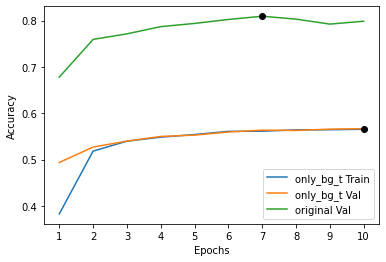

In [74]:
import numpy as np

plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.plot(range(1, num_epochs+1), only_bg_t_train_acc_history_18, label="only_bg_t Train")
plt.plot(range(1, num_epochs+1), only_bg_t_val_acc_history_18, label="only_bg_t Val")
plt.plot(range(1, num_epochs+1), original_val_acc_history_18, label="original Val")

plt.plot(np.argmax(only_bg_t_val_acc_history_18) + 1, np.max(only_bg_t_val_acc_history_18).item(), "ko")
plt.plot(np.argmax(original_val_acc_history_18) + 1, np.max(original_val_acc_history_18).item(), "ko")

plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()


In [76]:
evaluation(model_18, dataloaders_dict['only_bg_t/val'])

evaluation(model_18, dataloaders_dict['original/val'])


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor(0.5665, device='cuda:0', dtype=torch.float64)
tensor(0.7986, device='cuda:0', dtype=torch.float64)
